[View in Colaboratory](https://colab.research.google.com/github/adowaconan/Deep_learning_fMRI/blob/master/4_2_Autoencoder_in_fMRI_continue_(VAE).ipynb)

# Import the data fMRI data

In [1]:
!pip install -U -q PyDrive
!pip install tqdm
!apt-get install swig
!pip install -U pymvpa2
!pip install -U seaborn

# this lets you access to googel drive shared files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# why not numpy?
import numpy as np
import zipfile
from sklearn.metrics import roc_auc_score


from glob import glob # useless
from tqdm import tqdm # maybe useful
import pickle # very useful
from collections import Counter # I'm a counter
from mvpa2.mappers.fx import mean_group_sample # pymvpa
from mvpa2.generators.partition import NFoldPartitioner # pymvpa
from mvpa2.base.node import ChainNode # pymvpa
from mvpa2.generators.resampling import Balancer # pymvpa
from mvpa2.generators.base import Sifter # pymvpa
from mvpa2.mappers.base import Mapper # pymvpa
from keras.layers import Dense,Dropout,BatchNormalization
from keras.layers import Input, AveragePooling3D,Reshape
from keras.layers import Conv2D,Conv2DTranspose
from keras.layers import GaussianNoise # add noise to our data
from keras.layers import Flatten,Dense,LeakyReLU,Conv3DTranspose
from keras.models import Model
import keras
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
from sklearn import metrics
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

data_id = 'https://drive.google.com/open?id=1sMQh_8qhCwN7N1yM8mTEBT9m8q7l_0iv'.split('id=')[-1]
zip_import = drive.CreateFile({'id':data_id})
zip_import.GetContentFile('{}'.format('all_bin.pkl'))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,080 kB of archives.
After this operation, 5,657 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig3.0 amd64 3.0.10-1.2 [1,074 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig amd64 3.0.10-1.2 [6,384 B]
Fetched 1,080 kB in 1s (782 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.10-1.2_amd64.deb ...
Unpacking swig3.0 (3.0.10-1.2) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.10-1.2_amd64.deb ...
Un

Using TensorFlow backend.


# Read condition

## Experiment:

### Subjects in the sanner, and were instructed to read the word repeatedly as it was present. The words can be divided into 2 semantic categories: living animals and non-living tools

## words:

'llave', 'lapiz', 'tijera', 'aguja', 'pinza', 'sierra', 'clavo',
'pincel', 'alicate', 'tuerca', 'navaja', 'cepillo', 'taladro',
'soplete', 'tornillo', 'cuchara', 'martillo', 'cuchillo', 'tigre',
'gallo', 'perro', 'oveja', 'cerdo', 'gorila', 'burro', 'yegua',
'ardilla', 'conejo', 'gallina', 'caballo', 'ballena', 'pantera',
'camello', 'tortuga', 'elefante', 'canguro'
<br />**can you divide them?**

In [0]:
from IPython.display import Image
image_id = 'https://drive.google.com/open?id=1qZfXGiqtQ9g5DJsCtb_Injy_tSCEJ3dG'.split('id=')[-1]
image = drive.CreateFile({'id':image_id})
image.GetContentFile('{}'.format('words.png'))


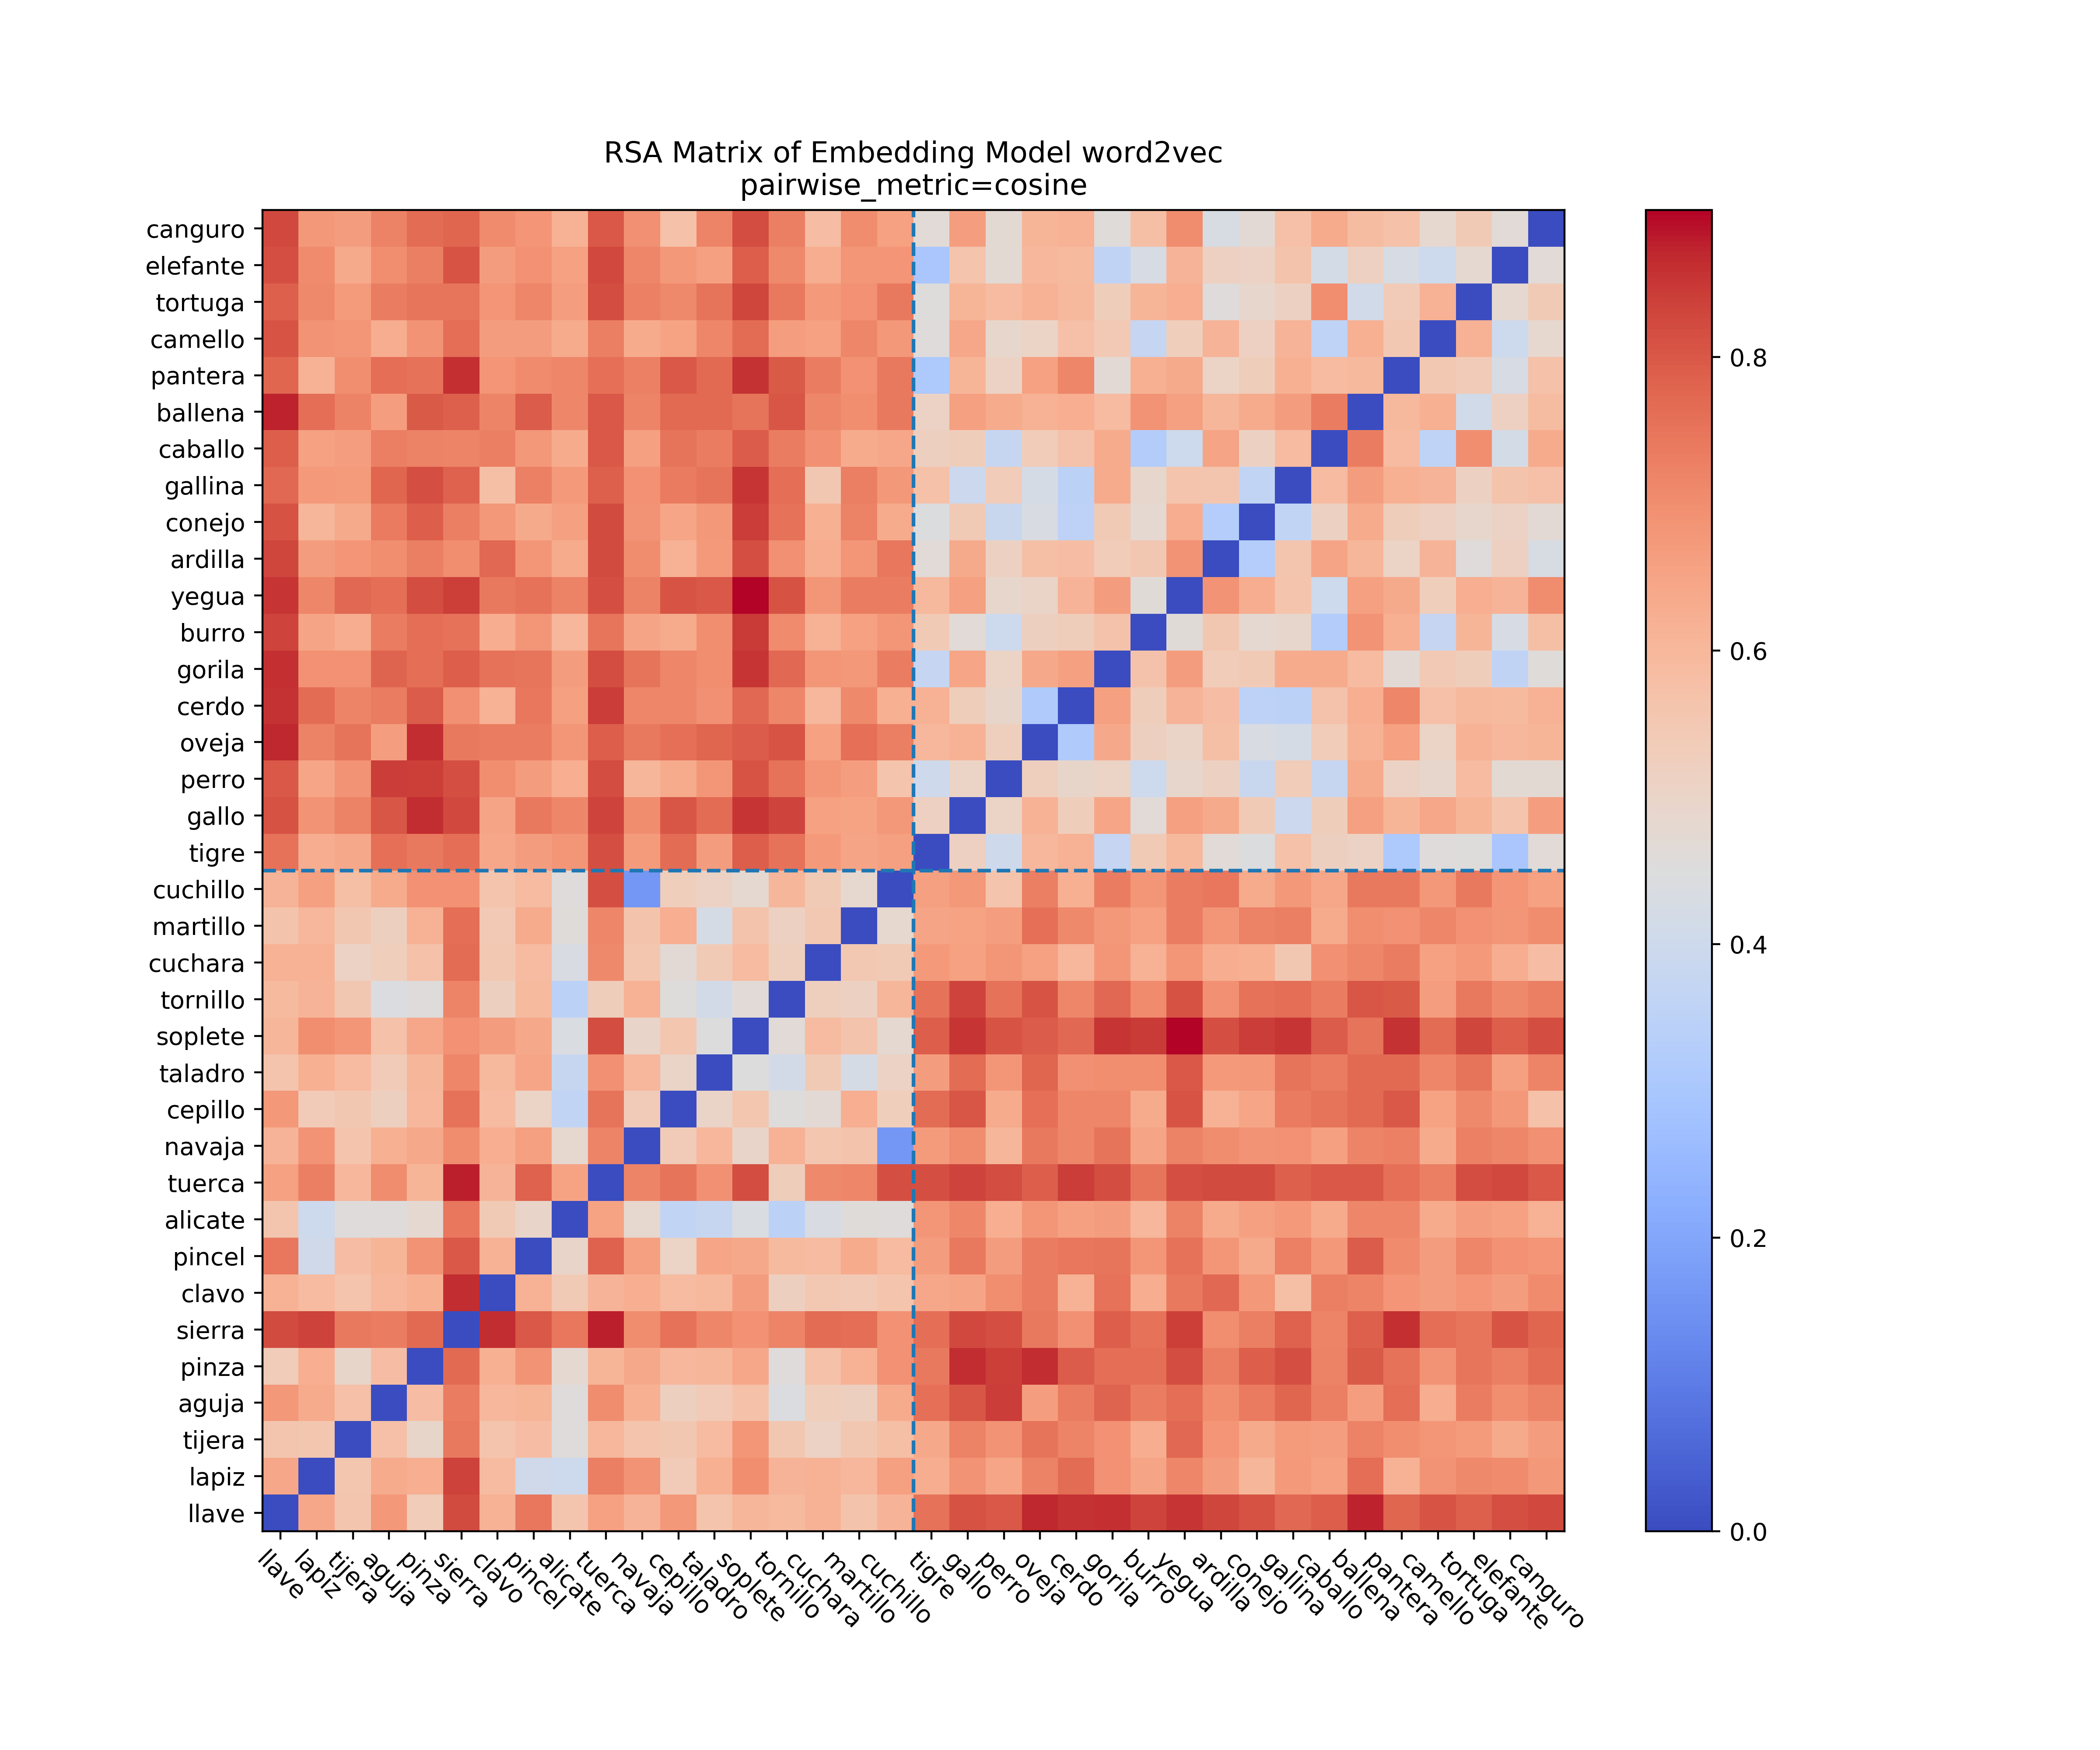

In [3]:
Image('words.png',height=800)

# Select the read condition

In [0]:
dataset_ = pickle.load(open('all_bin.pkl','rb'))
dataset = dataset_[dataset_.sa.context == 'read']

In [5]:
print(dataset.summary())

Dataset: 1544x16130@float32, <sa: categories,chunks,context,id,targets,time_coords,time_indices,trials,words>, <fa: voxel_indices>, <a: imgaffine,imghdr,imgtype,mapper,voxel_dim,voxel_eldim>
stats: mean=8.95748e-10 std=0.993167 var=0.98638 min=-6.82599 max=6.5985

Counts of targets in each chunk:
  chunks\targets animal tool
                   ---   ---
        0          111   111
        2          110   111
        4          110   110
        6          108   115
        8          109   109
       10          108   110
       12          111   111

Summary for targets across chunks
  targets mean  std min max #chunks
  animal   110 1.18 108 111    7
   tool    111 1.77 109 115    7

Summary for chunks across targets
  chunks mean std min max #targets
    0     111  0  111 111     2
    2     110 0.5 110 111     2
    4     110  0  110 110     2
    6     112 3.5 108 115     2
    8     109  0  109 109     2
   10     109  1  108 110     2
   12     111  0  111 111     2
Sequence s

In [0]:
import keras
from keras.layers                                  import Conv3D,Dense,Dropout,BatchNormalization
from keras.layers                                  import Input, AveragePooling3D,MaxPooling3D,Conv2DTranspose
from keras.layers                                  import Flatten,LeakyReLU,UpSampling3D,ThresholdedReLU
from keras.layers                                  import GlobalAveragePooling3D,Permute,GlobalMaxPool2D
from keras.layers                                  import Conv2D,GlobalAveragePooling2D,UpSampling2D
from keras.layers                                  import AveragePooling2D,MaxPool2D,merge
from keras.layers                                  import GaussianNoise,GaussianDropout
#from keras.layers import ReLU
from keras.models                                  import Model,Sequential
from keras.layers.noise                            import GaussianNoise,AlphaDropout
from keras.callbacks                               import ModelCheckpoint,TensorBoard,EarlyStopping
from keras                                         import backend as K
from keras                                         import regularizers
from keras.layers                                  import Reshape
from keras.layers                                  import Conv3DTranspose,Activation, Lambda,Multiply
from keras.layers                                  import Layer
from keras.losses                                  import mse





# Function used to make a callback list

## call back is used to monitor the training and validating of the deep neural network
## check point: used to save the best score model weights
## early stop: used to ternimate the training if no better score reaches

In [0]:
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          =monitor,# saving criterion
                                 save_best_only   =True,# save only the best model
                                 mode             =mode,# saving criterion
                                 period           =frequency,# frequency of check the update 
                                 verbose          =verbose# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          =monitor,
                                 min_delta        =min_delta,
                                 patience         =patience,
                                 verbose          =verbose, 
                                 mode             =mode,
                                 )
    return [checkPoint,earlyStop]

# loss of VAE = recontruction loss + $\beta$ * KL divergence loss of the sampling layer, $\beta = 1$
# if $\beta \neq 1$, it is called $\beta-$VAE 
# $$\text{KL divergence loss of the sampling layer} = - 0.5 * \sum(1 + log(\sigma) - \mu^2 - exp(log(\sigma)))$$
# where $\mu$ and $\sigma$ are learned from the input data
# To sample data from a Gaussian distribution that controlled by the $\mu$ and $\sigma$ learned from the inputs, we add a noise term $\epsilon$ to the distribution and sample from the distribution
# $$samples = tahn(\mu + exp[0.5 * log(\sigma)] * \epsilon)$$
# why use tahn? It is because we want the sampled outputs restricted between -1 and 1 for later if we want to visualize the learned representations of the latent layer
# of course you can use sigmoid function to constraint the value between 0 and 1, which seems to be easier and more intuitive.

# Define an object function to add KL divergence loss to the total loss.

1. The DL divergence loss is only for the latent layers: mu, log_var, and sampled_z
2. The loss is added by mini-batches (many tensorflow implementation on github does not do that)

In [0]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self,reg = 'vae', beta = 100, capacity = 0,*args, **kwargs):
        self.is_placeholder = True
        self.reg = reg
        self.beta = beta
        self.capacity = capacity
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        if self.reg == 'bvae':
            mu,log_var = inputs
            
            kl_batch            = - .5 * K.sum(1 + log_var -
                                               K.square(mu) -
                                               K.exp(log_var), axis=-1)
            kl_batch            = self.beta * K.abs(kl_batch - self.capacity/K.int_shape(mu)[1])
            
            self.add_loss(K.mean(kl_batch),inputs=inputs)
            return inputs
        else:
            mu, log_var         = inputs
    
            kl_batch            = - .5 * K.sum(1 + log_var -
                                               K.square(mu) -
                                               K.exp(log_var), axis=-1)
    
            self.add_loss(K.mean(kl_batch), inputs=inputs)
    
            return inputs
    


# The connection layer between mu, log_var and the sampled_z

$$z \approx N(\mu,exp(log(\sigma^2)))$$
$$z = \mu + exp(log(\sigma^2))*\epsilon$$
$\epsilon$ is the key here to enable the sampling process as well as adding gaussian variation (not noise) to the resampling and reconstruction process

In [0]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch             = K.shape(z_mean)[0]
    dim               = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon           = K.random_normal(stddev=0.5,shape=(batch, dim))
    return K.tanh( z_mean + K.exp(0.5 * z_log_var) * epsilon)#mu + sigma * eps

# Define a keras layer for adding customized layer loss to the total losses

## this is a very useful customized layer because it controls the total activation value for one single layer.
## say, you want to have the latent layer to be very sparse, you usually just add a L1 loss to the total losses
## but you cannot control for how much the activation should actually be
## this function is to compare the proposed loss value to the distribution of the activations of the target layer:

$$KL(\rho,\bar{\rho}) = \rho * log(\frac{\rho}{\bar{\rho}}) + (1 - \rho)*log(\frac{1- \rho}{1-\bar{\rho}})$$
$\rho$ is the proposed value, and $\bar{rho}$ is the average activation of the layer

In [0]:
class _sparse_reg(Layer):
    """
    for sparse regularization in keras layers
    rho: desired average activation of the hidden units
    beta: weight of sparsity penalty term
    """
    def __init__(self,
                 rho                = 0.02,
                 beta               = 1,*args, **kwargs):
        self.is_placeholder         = True
        self.rho                    = rho
        self.beta                   = beta
        super(_sparse_reg,self).__init__(*args,**kwargs)
        
    def call(self,inputs):
        #return 100000*K.shape(inputs) # usefule for debug
        # axis 0 size is batch_size
        # axis 1 size is layer_size
        self.rho_bar                = K.mean(inputs,axis = 0)# average over the batch samples
        epsilon                     = 1e-8 # avoid divided by zero
        KLs                         = self.rho * K.log(self.rho / (self.rho_bar+epsilon)) + (1 - self.rho) * K.log(1 - self.rho) / (1 - (self.rho_bar+epsilon))
        self.add_loss(self.beta * K.sum(KLs),
                      inputs        = inputs)# mean over the layers units
        return inputs

# The redundent part of the autoencoder, or most of the DNN models

## each layer, it should contain these parts: dense layer $\rightarrow$ batch normalization (can ignore if alpha dropout and selu is used) $\rightarrow$ activation function $\rightarrow$ dropout layer

## within the dense layer: 
1. how many neurons I want in this layer?
2. how much of the neurons should be set to zero when they are close to zero? (sparsity)
3. how much of the weights that connect neurons from the last layer to the current layer should be set to zero when they are close to zero? (simplicity)
4. how to initialize the weights?
5. do I add constant bias to the dot product?

In [0]:
class stacked_perceptron(object):
    """
    to construct stacked layers of dense-batchnormaization-activation-layers
    edit: batch normalization is no used due to activation SELU
    https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9
    https://arxiv.org/pdf/1706.02515.pdf
    """
    def __init__(self,
#                 inputs,
                 hidden_units, # number of neurons of the dense layer
                 beta                                       = 1, # L1 regularization value
                 lamda                                      = 1,# L2 regularization, used exclusively in parameters regularization
                 dropout_func                               = AlphaDropout,# special drop out function: https://arxiv.org/pdf/1706.02515.pdf
                 dropout_rate                               = 0.2,# dropout rate
                 name                                       = [1,1,'encode'],# the way of naming the layers
                 kernel_regularizer                         = regularizers.l1_l2,# parameter regularization function: elatic
                 kernel_initializer                         ='he_normal',# initialize the parameter method
                 activation                                 = 'selu',# self normalizing NN
                 alpha                                      = 0.3, # not used
                 l1                                         = False, # default of not using L1 activation regularization
                 use_bias                                   = True,# defult of using bias terms in the dense layers
                 batch_normal                               = True,# defult of using batch normalization
                 ):
#        self.inputs = inputs
        self.hidden_units                                   = hidden_units
        self.kernel_regularizer                             = kernel_regularizer
        self.kernel_initializer                             = kernel_initializer
        self.beta                                           = beta
        self.lamda                                          = lamda
        self.dropout_func                                   = dropout_func
        self.dropout_rate                                   = dropout_rate
        self.name                                           = name
        self.activation                                     = activation
        self.alpha                                          = alpha
        self.l1                                             = l1
        self.use_bias                                       = use_bias
        self.batch_normal                                   = batch_normal
    def __call__(self,net):
        ####################### dense layer block ###################################################
        if self.l1: # if regularize the activation output
            net = Dense(units                               = self.hidden_units,
                        use_bias                            = self.use_bias,
                        kernel_initializer                  = self.kernel_initializer,
                        kernel_regularizer                  = self.kernel_regularizer(1e-6,self.lamda),
                        activity_regularizer                = regularizers.l1(self.beta),
                        name                                = 'dense_layer{}_{}_{}'.format(self.name[0],
                                                                                           self.name[1],
                                                                                           self.name[2])
                        )(net)
        else:
            net = Dense(units                               = self.hidden_units,
                        use_bias                            = True,
                        kernel_initializer                  = self.kernel_initializer,
                        kernel_regularizer                  = self.kernel_regularizer(1e-6,self.lamda),
#                        activity_regularizer = regularizers.l1(self.beta),
                        name                                = 'dense_layer{}_{}_{}'.format(self.name[0],
                                                                                           self.name[1],
                                                                                           self.name[2])
                        )(net)
        #################### end of dense layer block #################################################
        #################### batch normalization block ################################################
        if self.batch_normal:
            net = BatchNormalization(name                   = 'norm_layer{}_{}_{}'.format(self.name[0],
                                                                                          self.name[1]+1,
                                                                                          self.name[2]))(net)
        ################### end of batch normalization block ################################################
        ################### actiavtion block ##########################################################
        if type(self.activation) is not str:
            net = self.activation(name                      = 'activation_layer{}_{}_{}'.format(self.name[0],
                                                                                                self.name[1]+2, 
                                                                                                self.name[2]),
                                  alpha                     = self.alpha)(net)
        else:
            net = Activation(activation = self.activation,
                             name                           = 'activation_layer{}_{}_{}'.format(self.name[0],
                                                                                                self.name[1]+2, 
                                                                                                self.name[2]),
                              )(net)
        ################### end of activation block ######################################################
        ################### dropout layer block ##########################################################
        net = self.dropout_func(rate                        = self.dropout_rate,
                      name                                  = 'drop_layer{}_{}_{}'.format(self.name[0],
                                                                                          self.name[1]+3,
                                                                                          self.name[2]))(net)
        
        return net

# Define the $\beta$ Variation Autoencoder

In [0]:
def betaVariationAutoencoder_sparse(shape, 
                             hidden_units                       = [512,128],
                             dropout_rate                       = 0.2,
                             latent_dim                         =100,
                             beta                               =1,
                             lamda                              =1,
                             lr                                 =1e-4,
                             decay                              =1e-9,
                             reg                                ='bvae',
                             BETA                               =100,
                             capacity                           =50,
                             rho                                =0.02,
                             sparse_beta                        =1
                             ):
    """
    Beta Variational Autoencoder with sparsity enforced in the sampled layer
    
    Beta is to control for the representation learning
    
    Inputs
    ---------------------
    shape:          input shape, int, n_features/n_voxels
    hidden_units:   structure of the hidden layers and their units, list of int, [1st layer units, 2nd layer units,...]
    dropout_rate:   rate of dropout for the dropout layers
    latent_dim:     latent dimensionality, int, n_neurons of the z_mu, z_log_var, and z nodes
    beta:           L1 loss regularization value, used for regularizing activation outputs
    lamda:          L2 loss regularization value, used for regularizing parameters
    lr:             learning rate of the optimizer
    decay:          schedule learning rate change for the optimizer
    reg:            latent space regularization strategy, we only have 'bvae' implemented here
    BETA:           control for the beta variational learning, int, 1 means the original VAE, > 1 means higher weight of the 
                        KL divergence loss in the total loss
    capacity:       ask the beta VAE try to use less than full latent space to distangle the features
    rho:            proposed value for the activation
    sparse_beta:    weights on the sparsity
    
    """
    ######################################## input layer ############################################
    ############################# takes just the input features #####################################
    inputs            = Input(shape                                        = (shape,),
                              batch_shape                                  = (None,shape),
                              name                                         = 'inputs',
                              dtype                                        = 'float32'
                              )
    ####################################### add noise to the inputs #################################
    ############################ Gaussian noise #####################################################
    inputs_            = GaussianNoise(stddev = .5)(inputs)
    ###################################### encoding layers ##########################################
    ############################# determined by the hidden units ####################################
    ############################# no L1 activation regularization ###################################
    encode_           = inputs_
    for ii,hidden_unit in enumerate(hidden_units):
        encode_       = stacked_perceptron(hidden_unit,
                                           beta                            = beta, # deinfed, but not used
                                           lamda                           = lamda,
                                           dropout_rate                    = dropout_rate,
                                           name                            = [ii+1,1,'en'],
                                           use_bias                        = True,
                                           batch_normal                    = False
                                           )(encode_)
    ##################################### end of encoding layers ####################################
    ##################################### latent nodes: z_mu, z_log_var #############################
    ##################################### with L1 activation regularization #########################
    z_mean            = stacked_perceptron(latent_dim,
                                           beta                            = beta, # defined and used
                                           lamda                           = lamda,
                                           dropout_rate                    = dropout_rate,
                                           name                            = ['_z_mean',1,'en'],
                                           l1                              = True,
                                           use_bias                        = True,
                                           activation                      = 'sigmoid',# constraint between 0 and 1
                                           batch_normal                    = False
                                           )(encode_)
    z_log_var         = stacked_perceptron(latent_dim,
                                           beta                            = beta,
                                           lamda                           = lamda,
                                           dropout_rate                    = dropout_rate,
                                           name                            = ['_z_log_var',1,'en'],
                                           use_bias                        = True,
                                           l1                              = True,
                                           activation                      = 'sigmoid',# constraint between 0 and 1
                                           batch_normal                    = False
                                           )(encode_)
    ###################################### reparameterize trick #######################################
    ###################################### add KL divergence loss to the model ########################
    z_mean,z_log_var = KLDivergenceLayer(reg                               = reg,
                                         beta                              = BETA,
                                         capacity                          = capacity,
                                         )([z_mean,z_log_var])
    ###################################### sample z from mu and log_var #################################
    z                = Lambda(sampling,
                              output_shape                                 = (latent_dim,),
                              name                                         = 'z',
                              )([z_mean,z_log_var])
    z                = Activation('sigmoid',name = 'z_activation')(z) # constraint between 0 and 1
    z                = _sparse_reg(rho = rho,beta = sparse_beta)(z)
    ##################################### psuedo sampling for feature visualization ####################
    #latern_computation = Lambda(psuedo_sampling,
    #                            output_shape                               = (latent_dim,),
    #                            name                                       = 'psuedo_z',
    #                            )([z_mean,z_log_var])
    ##################################### feature extractor without additional sampling noise ###########
    #feature_extractor = Model(inputs, [z_mean,z_log_var,latern_computation],
    #                          name                                         = 'feature_extractor')
    ##################################### encoder with addintional sampling noise #######################
    encoder          = Model(inputs,[z_mean,z_log_var,z],name              ='encoder')
    ##################################### start of decoder ##############################################
    latent_inputs    = Input(shape                                         = (latent_dim,),
                             name                                          = 'z_sampleing')
    ##################################### decoding layers ###############################################
    ##################################### also no L1 regularization #####################################
    decode_          = latent_inputs
    hidden_units_    = hidden_units
    hidden_units_.reverse()
    for ii,hidden_unit in enumerate(hidden_units_):
        decode_      = stacked_perceptron(hidden_unit,
                                          beta                             = beta,
                                          lamda                            = lamda,
                                          dropout_rate                     = dropout_rate,
                                          name                             = [ii+1,1,'de'],
                                          use_bias                         = True,
                                          batch_normal                    = False
                                          )(decode_)
    ##################################### output layer that reconstrcts the input #######################
    outputs          = Dense(units                                         = shape,
                             use_bias                                      = True,
                             name                                          ='outputs',
                             kernel_initializer                            = 'he_normal',
                             kernel_regularizer                            = regularizers.l1_l2(1e-6,lamda),
                             activity_regularizer                          = regularizers.l1(1e-4),# quite a high L1 regularization
                             activation                                    = 'sigmoid',# constraint between 0 and 1
                             )(decode_)
    decoder          = Model(latent_inputs,outputs,name                    ='decoder')
    outputs          = decoder(encoder(inputs)[2])
    autoencoder      = Model(inputs,outputs,name                           = 'vae')
    autoencoder.compile(optimizer                                          = keras.optimizers.Adam(lr    =lr,
                                                                                                   decay =decay),
                        loss                                               = keras.losses.binary_crossentropy,
                        metrics                                            = [keras.metrics.mae])
        
    return encoder,decoder,autoencoder

In [0]:
scaler           = MinMaxScaler() # scale the data between 0 and 1, and this is why we use sigmoid function as the activation function for last layer of the VAE
shape            = dataset.shape[1] # get the size of the data for the autoencoder
vae_model_name   = 'test.beta.vae.%s.%s.%s.hdf5'%('read','combined','full') # temporal model name for saving the weights
batch_size       = 16

# Make the callback lists

In [0]:
callBackList = make_CallBackList(vae_model_name,
                               monitor                      ='val_loss', # metric I care
                               mode                         ='min', # how I care
                               verbose                      =0,# print out the process
                               min_delta                    =1e-3,# how much difference it should make
                               patience                     =50, # early stop argument
                               frequency                    =1
                               )

# Build the VAE model with $\beta = 50$

In [0]:
encoder,decoder,autoencoder= betaVariationAutoencoder_sparse(
  shape, # input shape
  hidden_units      =[256,128,64], # layers and units in each layers
  dropout_rate      =0.4, # drop out rate for each hidden layer
  beta              =1e-5, # for activation sparsity
  lamda             =0.005, # for model simplicity
  lr                =1e-3, # learning rate
  decay             =1e-6, # schedule decay of the learning rate 
  latent_dim        =36, # latent space dimensionality 
  BETA              =50, # beta weight for the KL divergence variational layers
  capacity          =36, # = 36 words, I want only 36 of them matters the most (a big assumption explicitly encoded in the VAE model)
  rho               =0.03,
  sparse_beta       =1,
                                          )

In [23]:
print(encoder.summary(),decoder.summary(),autoencoder.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 16130)        0                                            
__________________________________________________________________________________________________
gaussian_noise_3 (GaussianNoise (None, 16130)        0           inputs[0][0]                     
__________________________________________________________________________________________________
dense_layer1_1_en (Dense)       (None, 256)          4129536     gaussian_noise_3[0][0]           
__________________________________________________________________________________________________
activation_layer1_3_en (Activat (None, 256)          0           dense_layer1_1_en[0][0]          
__________________________________________________________________________________________________
drop_layer

# This is one of good practices when working with deep neural network: passing zeros through the model and knows the initialized losses of the model
# the first result is the initial loss, which is the reconstruction loss + KL loss of the model. Since the input values are all zeros, the loss represents the total weights
# the second result is the initial similarity between the inputs and the reconstructed inputs. Here, 0 means a good initialization because it means no positive or negative correlations

In [24]:
print('initial loss {:.4f}'.format(autoencoder.evaluate(np.zeros(dataset.shape),np.zeros(dataset.shape),
                                                                batch_size = batch_size,
                                                                verbose     = 0
                                                                )[0]
                                            )
            )
print('initial metrics {:.4f}'.format(autoencoder.evaluate(np.zeros(dataset.shape),np.zeros(dataset.shape),
                                                                batch_size = batch_size,
                                                                verbose     = 0
                                                                )[1]
                                            )
            )

initial loss 449.2427
initial metrics 0.4972


# I am going to cheat a little bit by training the VAE with all the data instead of re-initialize it and train it with each fold of the cross validation
# I am still going to use a cross validation to train the VAE, but it serves a different purpose than the common cross-validation loop


In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
print_train = 0
epochs      = 3000
label_map = {'animal':[0,1],
             'tool':[1,0]}
data            = dataset.samples.astype('float32')
data            = scaler.fit_transform(data)
ids             = dataset.sa.id.astype(int)
chunks          = dataset.sa.chunks
labels          = np.array([label_map[item] for item in dataset.targets])[:,-1]
sample_indecies = np.arange(len(labels))
blocks          = [np.array([ids[ids    == target],
                    chunks[ids          == target], 
                    labels[ids          == target],
                    sample_indecies[ids == target]
                    ]) for target in np.unique(ids)]
block_labels    = np.array([np.unique(ll[-2]) for ll in blocks]).ravel()
cv = StratifiedShuffleSplit(n_splits=100,test_size=0.15,random_state=12345)
for z,(training,validation) in enumerate(cv.split(blocks,block_labels)):
    idx_training    = np.concatenate([blocks[tr_el][-1] for tr_el in training])
    idx_validation  = np.concatenate([blocks[te_el][-1] for te_el in validation])
    if z > 3: 
        pass
    else:
        print('autoencoder loss starts with {:.4f}'.format(autoencoder.evaluate(
                                              data,
                                              data,
                                              batch_size                    = batch_size,
                                              verbose                       = 0
                                                                      )[0]))
        # fit the autoencoder with train data, and validate with validation data
        # remember the callbacks? That is why we need validation data
        # if the validation loss goes down, we save the model weights for that moment
        # if the validation loss don't go down for a couple epochs, we stop training
        history                 = autoencoder.fit(  
                                    data[idx_training],data[idx_training],# input, output
                                    batch_size                              = batch_size,# min batch size
                                    epochs                                  = epochs,# just lots of epochs
                                    validation_data                         = (data[idx_validation],data[idx_validation]),# split the last 10% of the data as the validation data
                                    verbose                                 = print_train,# print out the process
                                    callbacks                               = callBackList # call back functions
                                    )
        autoencoder.load_weights(vae_model_name) # load the saved best model weights
        # let's look at the current model loss with all the training + validation data combined
        training_loss = autoencoder.evaluate(data,data,
                                             batch_size                     = batch_size,
                                             verbose                        = 0
                                             )
        print('autoencoder loss = {:.4f},consine = {:.4f}'.format(training_loss[0],training_loss[1]))

autoencoder loss starts with 531.3871
autoencoder loss = 45.6595,consine = 0.4957
autoencoder loss starts with 45.6611
autoencoder loss = 45.6669,consine = 0.4957
autoencoder loss starts with 45.6643
autoencoder loss = 45.6563,consine = 0.4957
autoencoder loss starts with 45.6620
autoencoder loss = 45.6593,consine = 0.4957


# using the full encoder (with the Gaussian sampling layer) to get extra data from the inputs

In [0]:
df_gen = []
n = 1;np.random.seed(12345)
ids             = np.concatenate([dataset.sa.id.astype(int) for _ in range(n)])
chunks          = np.concatenate([dataset.sa.chunks for _ in range(n)])
labels          = np.concatenate([np.array([label_map[item] for item in dataset.targets])[:,-1] for _ in range(n)])
sample_indecies = np.concatenate([np.arange(dataset.shape[0]) for _ in range(n)])


In [0]:
blocks          = [np.array([ids[ids    == target],
                    chunks[ids          == target], 
                    labels[ids          == target],
                    sample_indecies[ids == target]
                    ]) for target in np.unique(ids)]
block_labels    = np.array([np.unique(ll[-2]) for ll in blocks]).ravel()

for _ in range(n):
    mu_animal,sigma_animal,z_animal = encoder.predict(MinMaxScaler().fit_transform(data[dataset.sa.targets == 'animal']))
    mu_tool, sigma_tool,z_tool      = encoder.predict(MinMaxScaler().fit_transform(data[dataset.sa.targets == 'tool']))
    df_animal = pd.DataFrame(z_animal,columns=['%d'%(d+1) for d in range(36)])
    df_animal['labels'] = 'animal'
    df_tool = pd.DataFrame(z_tool,columns=['%d'%(d+1) for d in range(36)])
    df_tool['labels'] = 'tool'
    df_gen.append(df_animal)
    df_gen.append(df_tool)
df_gen = pd.concat(df_gen)

In [0]:
df_animal = df_gen[df_gen['labels'] == 'animal']
df_tool   = df_gen[df_gen['labels'] == 'tool'  ]

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [92]:
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit
X = df_gen.iloc[:,:-1].values
y = df_gen['labels'].values
y = np.array([label_map[item] for item in y])[:,-1]
scores = []
cfm    = []
cv     = StratifiedShuffleSplit(n_splits=30,test_size=0.15,random_state=12345)
for fold,(train,test) in enumerate(cv.split(blocks,block_labels)):
    idx_train = np.concatenate([blocks[tr_el][-1] for tr_el in train])
    idx_test  = np.concatenate([blocks[te_el][-1] for te_el in test])
    
    X_train = X[idx_train]
    y_train = y[idx_train]
    
    X_test  = X[idx_test]
    y_test  = y[idx_test]
    
    clf            = SVC(probability=True,random_state=12345,kernel='linear')
    print('fitting')
    clf.fit(X_train,y_train)
    print('predicting')
    preds          = clf.predict_proba(X_test)[:,-1]
    score1         = roc_auc_score(y_test,preds)
    threshold_     = Find_Optimal_Cutoff(y_test,preds)[0]
    score2         = matthews_corrcoef(y_test,preds>threshold_)
    score3         = f1_score(y_test,preds>threshold_)
    score4         = log_loss(y_test,preds,)
    tn, fp, fn, tp = confusion_matrix(y_test,preds>threshold_).ravel()
    print(classification_report(y_test,preds>threshold_))
    scores.append([score1,score2,score3,score4])
    cfm.append([tn, fp, fn, tp])

fitting
predicting
             precision    recall  f1-score   support

          0       0.55      0.49      0.52       134
          1       0.41      0.48      0.44       101

avg / total       0.49      0.49      0.49       235

fitting
predicting
             precision    recall  f1-score   support

          0       0.47      0.50      0.48       111
          1       0.52      0.49      0.51       124

avg / total       0.50      0.49      0.49       235

fitting
predicting
             precision    recall  f1-score   support

          0       0.45      0.53      0.48        99
          1       0.59      0.52      0.55       132

avg / total       0.53      0.52      0.52       231

fitting
predicting
             precision    recall  f1-score   support

          0       0.56      0.52      0.54       128
          1       0.46      0.50      0.48       105

avg / total       0.51      0.51      0.51       233

fitting
predicting
             precision    recall  f1-score   

In [0]:
scores = np.array(scores)
cfm    = np.array(cfm)

In [94]:
print('ROC AUC score = {:.3f} +/- {:.3f}\nf1 score = {:.3f} +/- {:.3f}'.format(
        scores.mean(0)[0],scores.std(0)[0],scores.mean(0)[-2],scores.std(0)[-2]
        ))

ROC AUC score = 0.506 +/- 0.030
f1 score = 0.474 +/- 0.102


In fact, with different time of generating features from the encoder, the results will be a bit different, so in practice, we should estimate such variance with multiple times of running the same pipeline

In [0]:
cm = cfm.mean(0).reshape(2,2)
cm = cm / cm.sum(axis=1)[:,np.newaxis]
cm = pd.DataFrame(cm,columns=['tool','animal'],index=['tool','animal'])

[Text(41.8,0.5,u'True'),
 Text(0.5,41.8,u'Predicted'),
 Text(0.5,1,u'Baseline Model')]

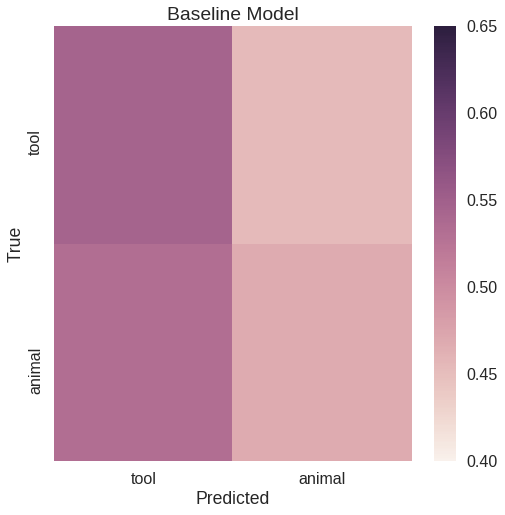

In [96]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm,ax=ax,vmin = 0.4,vmax = 0.65)
ax.set(ylabel = 'True', xlabel = 'Predicted',title = 'Baseline Model')

*multivariate decoding for prediction* aims at identifying biomarkers that can be used to carry out predictions about underlying states of the brain $\rightarrow$ maximal decoding performance is the goal, and success is determined by a model that can decode mental or physiological states from previous unseen data with high accuracy

---
*multivariate decoding for interpretation* aims at a better understanding of the human brain and does NOT requier high predictive accuracy $\rightarrow$ this approach is that as soon as a decoding model performs reliably better than chance, this demonstrates that there is structure in the data with respect to the conditions of interest, in binary cases

And the lower performance of interpretation approaches are caused by regularizations that force the model use relevant information other than irrelevant information that looks good but uninformative


[reference](https://www.biorxiv.org/content/biorxiv/early/2017/07/02/158493.full.pdf)

In [0]:
sampled_z = encoder.predict(MinMaxScaler().fit_transform(dataset.samples.astype('float32')))[2]
labels    = np.array([label_map[item] for item in dataset.sa.targets])[:,-1]

In [98]:
sampled_z.shape,labels.shape

((1544, 36), (1544,))

In [0]:
from matplotlib import pyplot as plt
from math import pi

In [0]:
N = 36
angles = [n / float(N) * 2. * pi for n in range(N)]
angles += angles[:1]


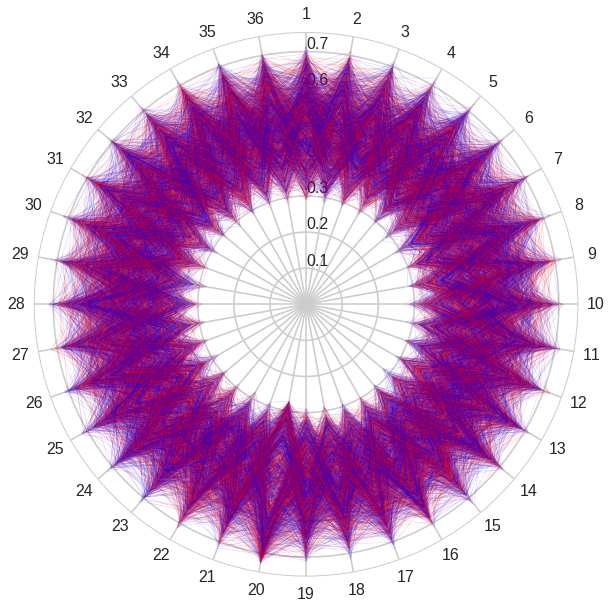

In [101]:
color = ['red','blue']
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,polar = True)
_=ax.set_theta_offset(pi / 2)
_=ax.set_theta_direction(-1)

_=ax.set(xticks = angles[:-1],xticklabels=['{}'.format(n+1) for n in range(N)])

ax.set_rlabel_position(0)
for row,label in zip(sampled_z,labels):
    values = list(row)
    values += values[:1]
    ax.plot(angles,values,linewidth=0.5,alpha=0.2,color=color[label])